In [1]:
library(ggplot2)
library(tidyr)
library(dplyr)
library(scales)
library(RColorBrewer)
library(ggtree)
library(ape)
library(cowplot)
library(ggtext)
library(stringr)
library(grid)
library(extrafont)

Warning message:
“package ‘ggplot2’ was built under R version 3.6.2”
Warning message:
“package ‘tidyr’ was built under R version 3.6.2”
Warning message:
“package ‘dplyr’ was built under R version 3.6.2”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“package ‘scales’ was built under R version 3.6.2”
ggtree v3.1.4  For help: https://yulab-smu.top/treedata-book/

If you use ggtree in published research, please cite the most appropriate paper(s):

1. Guangchuang Yu. Using ggtree to visualize data on tree-like structures. Current Protocols in Bioinformatics, 2020, 69:e96. doi:10.1002/cpbi.96
2. Guangchuang Yu, Tommy Tsan-Yuk Lam, Huachen Zhu, Yi Guan. Two methods for mapping and visualizing associated data on phylogeny using ggtree. Molecular Biology and Evolution 2018, 35(12):3041-3043. doi:10.1093/molbev/msy194
3. Guang

In [2]:

theme_set(theme_classic() + theme(text = element_text(size=20, family = "Times New Roman")))

options(StringsAsFactors=FALSE)
lineage_colors <- c("#E64B35FF","darkred","#6794a7", "#014d64", "#01a2d9" ,
                    "#7ad2f6" ,"#00887d", "#76c0c1", "lightblue", "gray"  )

lineage_names <- c('g2g-L2','L2','L4.1','L4.3','L4.4','L4.5','L4.7','L4.8','L4.x')

# Grid plot

In [3]:
# read in all p-values with <1e-5 from genome-to-genome analyses between any pair of Mtb-host genome
df <- read.table("../data//g2g-pvals.txt",h=F)
names(df) <- c("Mtb","CHR","BP","pval")

mhcResults <- read.table("../data/MHCimp.97.assoc.txt.gz",h=T)

# annotate basepair position
mhc <- mhcResults %>%
  mutate(ps = str_split(rs, ":", simplify = TRUE)[, 3])

df$P <- mhc[match(df$BP,mhc$ps),]$p_lrt
df$P <- ifelse(is.na(df$P) | df$CHR!=6 | df$Mtb!=97,df$pval,df$P)


In [4]:
   # Prepare the dataset for plotting
don <- df %>% 
    # Compute chromosome size
    group_by(CHR) %>% 
    summarise(chr_len=max(BP,na.rm=T)) %>% 
  
      # Calculate cumulative position of each chromosome
      mutate(tot=cumsum(as.numeric(chr_len))-chr_len) %>%
      select(-chr_len) %>%
  
      # Add this info to the initial dataset
      left_join(df, ., by=c("CHR"="CHR")) %>%
  
      # Add a cumulative position of each SNP
      arrange(CHR, BP) %>%
      mutate( BPcum=BP+tot) 



In [5]:
#define rectangulars for alternativing color between chromosomes
xstart <- don %>% filter(CHR<=23)%>% 
    group_by(CHR) %>% 
    slice(which.min(BPcum))
xend <- don %>% filter(CHR<=23)%>% 
    group_by(CHR) %>% 
    slice(which.max(BPcum)) 


rects <- data.frame(xstart = xstart$BPcum, xend = xend$BPcum, 
         col = letters[1:23])


In [6]:
#colors <- brewer.pal(9, "Oranges")
colors <- c("gray90","#fdcc8a","#fc8d59","#e34a33","#b30000") #reds

options(repr.plot.width=15, repr.plot.height=7)

p <- ggplot(data = don %>% filter(CHR<=23 | CHR=="X"), aes(x=BPcum, y=Mtb, size=-log10(P),
                                         color=-log10(P), alpha=-log10(P))) 

#add alternativing background
p <- p +  geom_rect(data=rects, aes(ymin=0, ymax=Inf, xmin=xstart,
                       xmax=xend, fill=col), alpha =0.5,inherit.aes = F)+
   scale_fill_manual(values = c(rep(c("white", "grey95"),11),"white")) + 
   guides(fill = "none") 

ppoint <-   p +    geom_point() +
    scale_size(range = c(0.001, 1),guide='none') +
  scale_colour_gradient2(name = expression(-log[10](P)),low = colors[1],  mid = colors[2], high = colors[5],midpoint=7.5,
                        breaks=c(5,8,10,12))+
    scale_alpha(range=c(0,1),guide='none') 



[1] 23  4

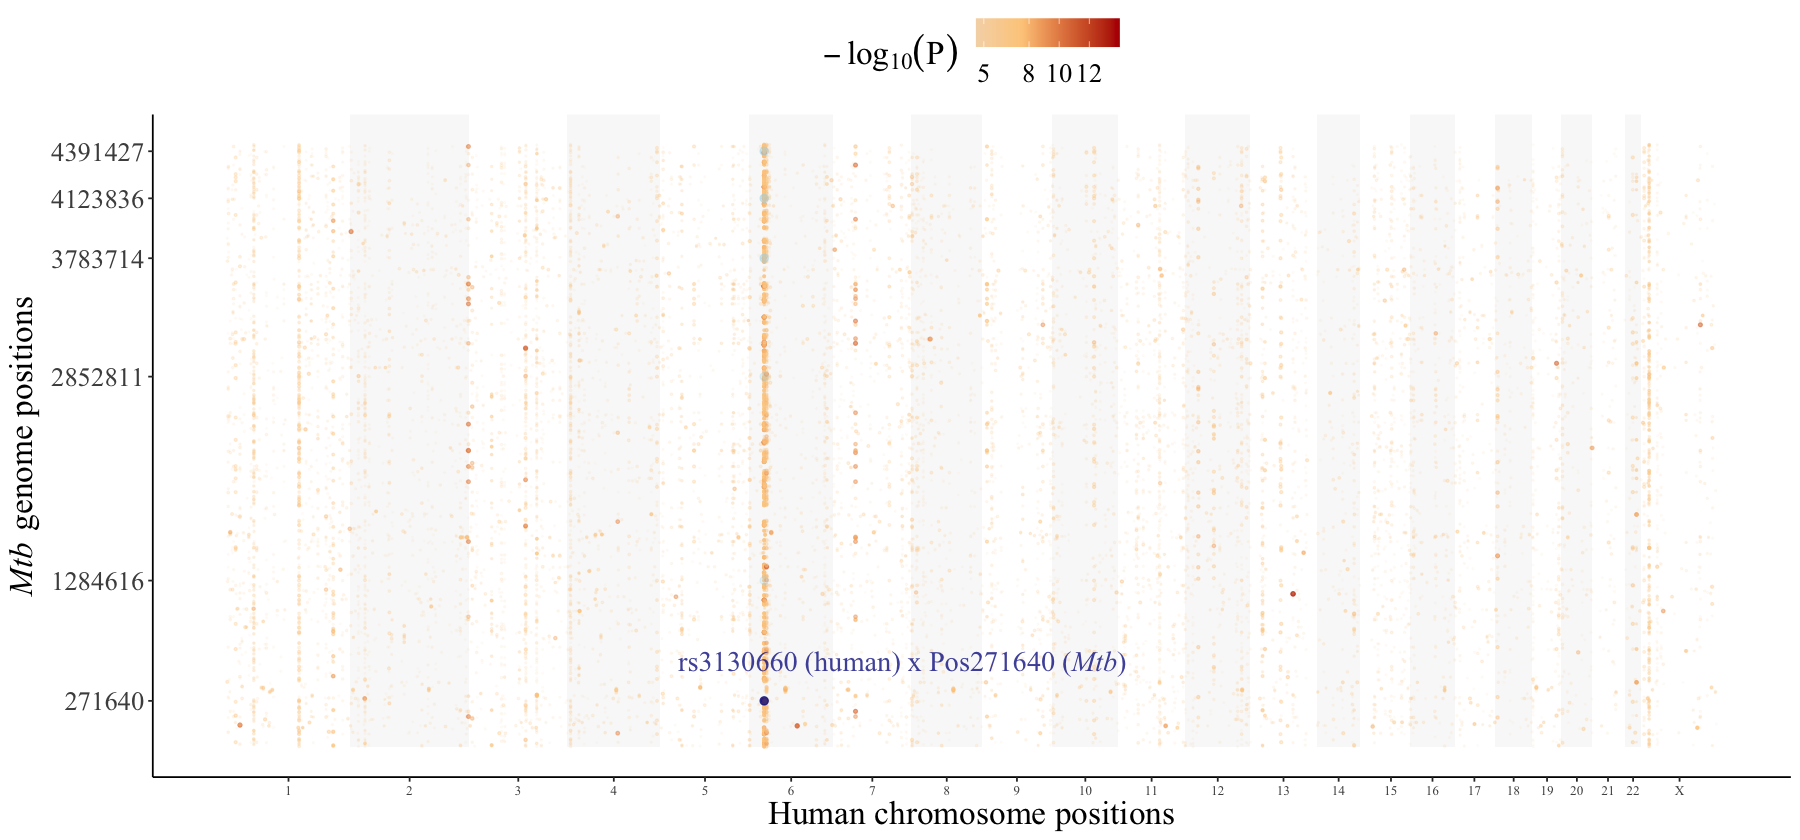

In [7]:
# adding random Mtb positions that are in high LD with top position

mtbpicked <- c(271640,1284616,2852811,3783714,4123836,4391427)
mtbpos <- read.table("../data/Mtb_pos.txt",h=F)
mtbpos$order <- c(1:1267)

ticks <- mtbpos[mtbpos$V1 %in% mtbpicked,2]

grid.plt <- ppoint +   geom_point(data=subset(don, BP=="30687614" & Mtb=="97"), size=2,col="darkblue") +
    geom_richtext(data=subset(don,BP=="30687614"& Mtb=="97"),color="darkblue", vjust=-.5,hjust=.2,
                   aes(label="rs3130660 (human) x Pos271640 (*Mtb*)"),size=6,show.legend=FALSE,
                 fill = NA, label.color = NA ,family="Times New Roman") +
    geom_point(data=subset(don,BP =="30687614" & Mtb %in% ticks[-1]),size=2,col="lightblue") +
    xlab("Human chromosome positions") + ylab(expression(paste(italic("Mtb"), " genome positions") ))

# adding ticks
rects$means <- rowMeans(rects %>% select(xstart,xend))
dim(rects)
grid.plt <- grid.plt +
 scale_y_continuous(breaks=ticks,labels=mtbpicked) +
 scale_x_continuous(breaks=rects$means,labels=c(c(1:22),"X")) +
theme(axis.text.x = element_text(angle = 0,size=8))

grid.plt + theme(legend.position="top")

# Manhattan plot of Pos271640 (*Mtb*) 

In [8]:
gwasResults <- read.table("../data//Pos271640_stats.txt.gz",h=T)
mhcResutls <- read.table("../data/MHCimp.97.assoc.txt.gz",h=T)

# annotate basepair position
mhc <- mhcResutls %>%
  mutate(ps = str_split(rs, ":", simplify = TRUE)[, 3])

#define cosumized plots
names(gwasResults) <- c("CHR","BP","P","z")

gwasResults$pval <- mhc[match(gwasResults$BP,mhc$ps),]$p_lrt
gwasResults$pval <- ifelse(is.na(gwasResults$pval) | gwasResults$CHR!=6, gwasResults$P,gwasResults$pval)


don <- gwasResults %>% 
  
  # Compute chromosome size
  group_by(CHR) %>% 
  summarise(chr_len=max(as.numeric(BP))) %>% 
  
  # Calculate cumulative position of each chromosome
  mutate(tot=cumsum(chr_len)-chr_len) %>%
  select(-chr_len) %>%
  
  # Add this info to the initial dataset
  left_join(gwasResults, ., by=c("CHR"="CHR")) %>%
  
  # Add a cumulative position of each SNP
  arrange(CHR, BP) %>%
  mutate( BPcum=BP+tot)

In [9]:
axisdf = don %>% group_by(CHR) %>% summarize(center=( max(BPcum) + min(BPcum) ) / 2 )

# the observed counts

p1 <- ggplot(don, aes(x=BPcum, y=-log10(pval))) +
    
    # Show all points
    geom_point( aes(color=as.factor(CHR)), alpha=0.8, size=1) +
    scale_color_manual(values = rep(c("grey","darkblue"), 23 )) +
    
    # custom X axis:
    scale_x_continuous( label = c(1:22,"X"), breaks= axisdf$center ) +
    #scale_y_continuous(expand = c(0, 0) ) +     # remove space between plot area and x axis

    xlab("Chromosome") + ylab(expression(-log[10](P))) + ylim(0,16) +
  
    # Custom the theme:
    theme( 
      legend.position="none",
      panel.border = element_blank(),
        axis.text.x = element_text(angle=0, vjust = 0.5,size=8),
      axis.title.y = element_text(vjust = 1)
      #panel.grid.minor.x = element_blank()
    )

#p1 <- p1 + scale_x_continuous(expand = c(0, 0)) 


In [10]:
# genomewide sig. threshold derived based on permutation
threshold <- 6.545361e-12
FLOT1manhattan <- p1 + geom_hline(yintercept=-log10(threshold), linetype="dashed", color = "red") +
     geom_hline(yintercept=-log10(5e-8), linetype="dashed", color = "black")

In [11]:
# adding p-values
text1 <- expression(P<6.55%*%10^-12)
text2 <- expression(P<5%*%10^-8)
grob1 <- grobTree(textGrob(text1, x=.7,  y=.72, hjust=0,
  gp=gpar(col="red", fontsize=20)))

grob2 <- grobTree(textGrob(text2, x=.7,  y=.5, hjust=0,
  gp=gpar(col="black", fontsize=20)))

FLOT1manhattan <- FLOT1manhattan + annotation_custom(grob1) + annotation_custom(grob2) 

# phylogeny tree of all collected isolates

In [12]:
Mytree <- read.tree("../data/all_tree.tre")

# read the sampling information data set
info <- read.table("../data/g2g_info_with_geno.txt",h=T)
info$lineage <- ifelse(info$X271640==1,"g2g-L2",as.character(info$final_lineage))

x <- as_tibble(Mytree)

oldlabel <- (Mytree$tip.label)
newlabel <- sapply(oldlabel,function(s){unlist(strsplit(s,"_"))[1]})
length(newlabel)

dim(x %>% filter(!is.na(label)))
                   
Mytree$tip.label <- newlabel


[1] 1602

[1] 1602    4

In [13]:
# drop the signle L1 strain for visualization
to_drop <- as.character(info[info$final_lineage == "L1" | info$passg2gQC==0,]$Name)

QCedtree <- drop.tip(Mytree,to_drop)

# draw tree 

ptree <- ggtree(QCedtree) #+ geom_tiplab()


ptree <- ptree %<+%  info + geom_tippoint(aes(color=lineage),size=1) #+ geom_tiplab()

plineage <- ptree + scale_color_manual(name="",values=lineage_colors) +
  theme(
    panel.grid.major = element_blank(), 
    panel.grid.minor = element_blank(),
    panel.background = element_rect(fill = "transparent",colour = NA),
    plot.background = element_rect(fill = "transparent",colour = NA)
  ) +
  guides(color = guide_legend(override.aes = list(size = 4)))


In [14]:
# flip L2 and L4 positions
p1 <- flip(plineage,2933,1557)

# highlight g2g-L2 branch
p2 <- p1 + geom_hilight(node=2938,fill=lineage_colors[1],alpha=.3,extend=10)


keepID <- info[!info$Name %in% to_drop,]$Name

# adding genotype information 
geno <- as.data.frame(na.omit(info[match(keepID,info$Name),5:ncol(info)]))

# pick only six positions for plotting
genonew <- geno %>% select(paste("X",mtbpicked,sep=""))

geno <- genonew
row.names(geno) <- keepID
colnames(geno) <- str_replace(colnames(genonew), "X", "")
geno[geno == 0] <- "Absent"
geno[geno == 1] <- "Present"

p3 <- gheatmap(p2,geno,offset=20,width=0.3,
               colnames=T,colnames_position = "top",colnames_angle = 90,
              colnames_offset_y = 70,hjust=1, font.size=3) +
    scale_fill_manual(values=c("grey","red"),name="g2g-L2 SNPs")


# adding label
treePlt <- p3 + geom_strip('Peru5210', 'Peru8538', barsize=3, color=lineage_colors[1], 
             label="g2g-L2", offset.text=15,fontsize=6,offset=-20,angle=90,hjust=.5,vjust=.1) +
    theme(text = element_text(size=20, family = "Times New Roman"))

treePlt <- treePlt + geom_strip('Peru3401', 'Peru8043', barsize=.5, color=lineage_colors[4],label="L4.3",
                    offset.text=15,fontsize=6,angle=90,offset=-30)


treePlt <- treePlt + geom_strip('Peru7786', 'Peru7313', barsize=.5, color="#7bccc4",label="L4.4-8",
                    offset.text=15,fontsize=6,hjust=.5,angle=90,offset=-50)

treePlt <- treePlt + geom_strip('Peru7693', 'Peru7121', barsize=.5, color=lineage_colors[3],label="L4.1",
                    offset.text=15,fontsize=6,hjust=.5,angle=90,offset=-30)





Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



# Combined plot


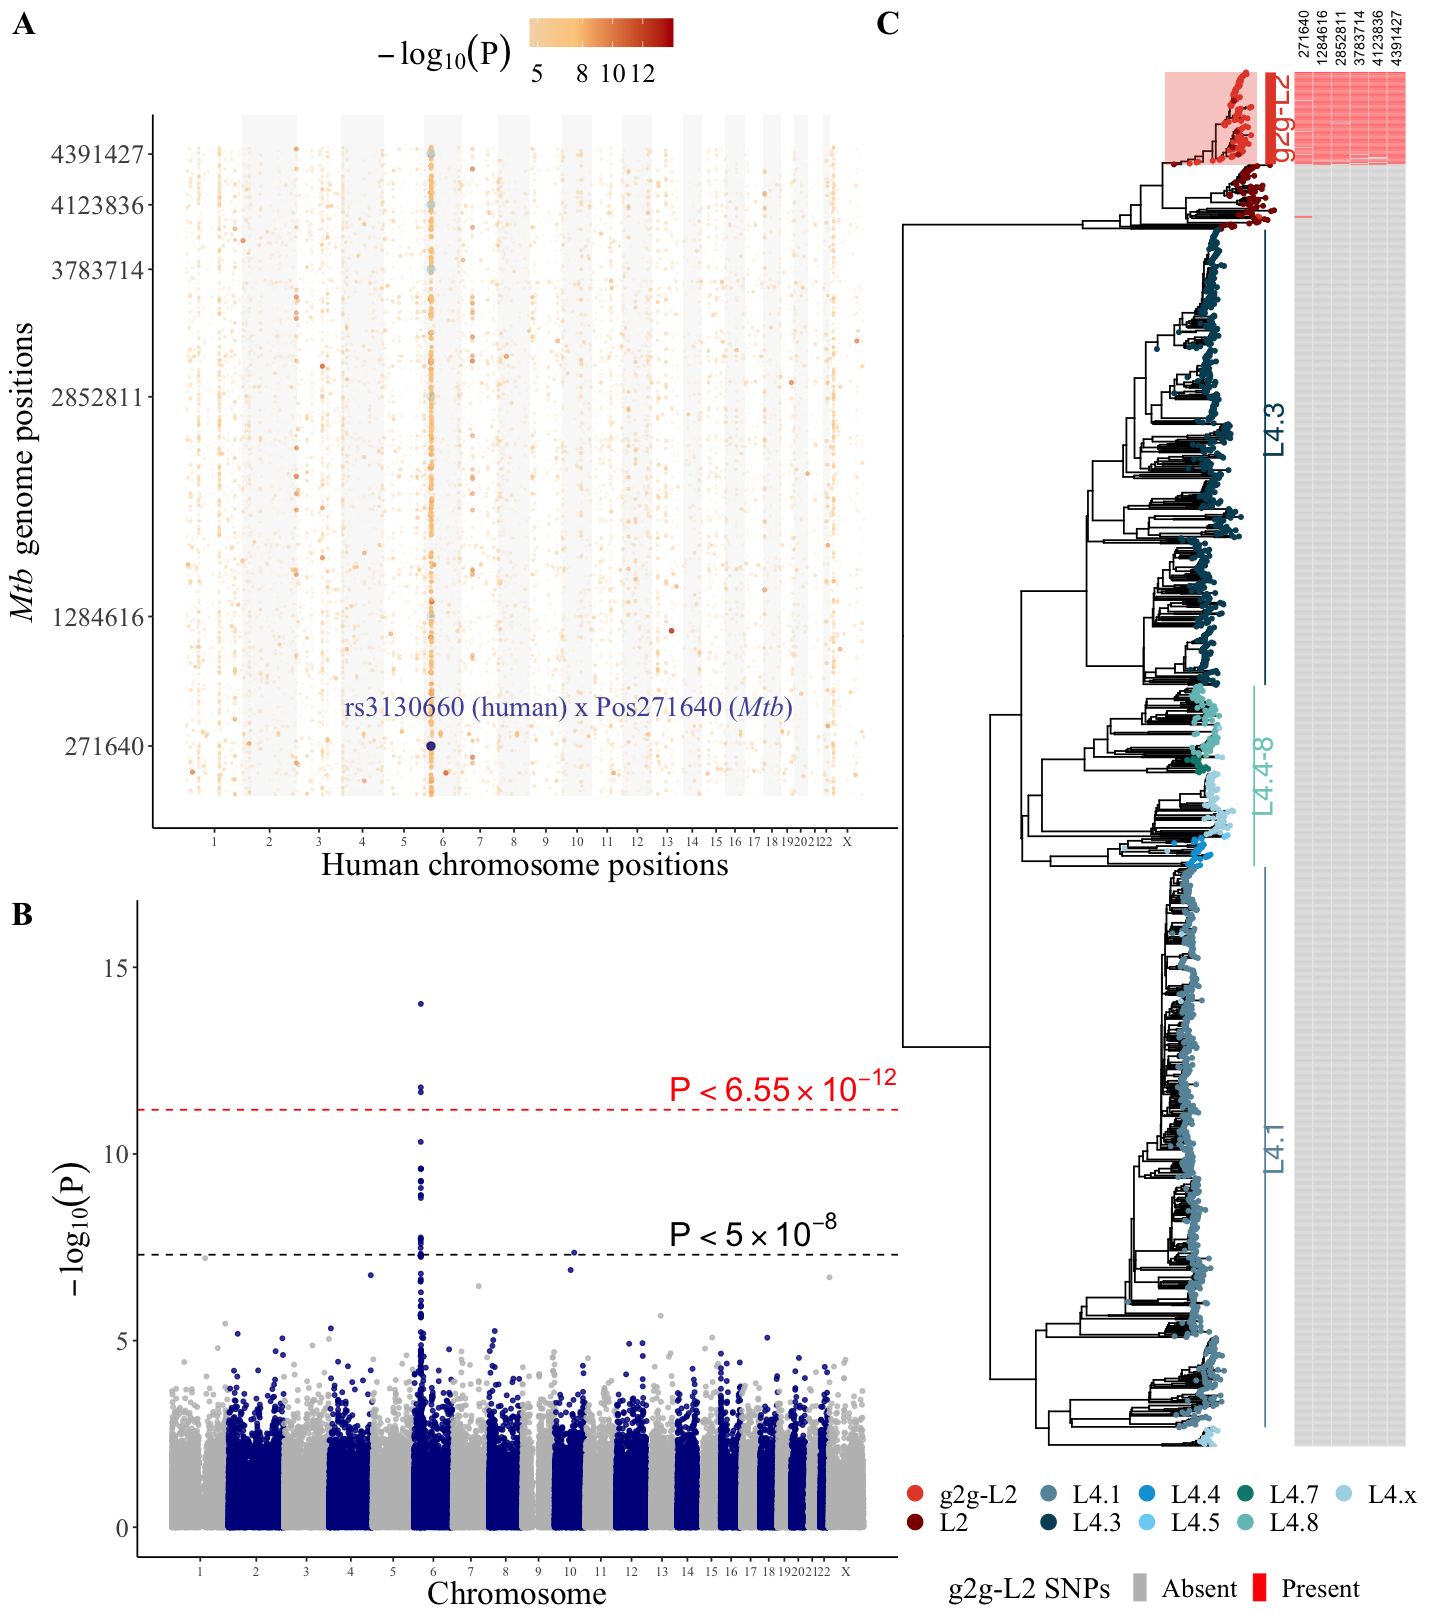

In [15]:
options(repr.plot.width = 12, repr.plot.height = 12.5)

P <- ggdraw() +
  draw_plot(grid.plt+ theme(legend.position="top"), x = 0, y = .45, width = .63, height = .55) +
  draw_plot(FLOT1manhattan, x = 0.03, y = 0, width = .6, height = .45) +
  draw_plot(treePlt + theme(legend.position = "bottom",legend.box = "vertical",
                           legend.key.width = unit(.3, 'cm'),
                            legend.title = element_text(size=18)),
            x = 0.6, y = 0, width = .4, height = 1) +
  draw_plot_label(label = c("A", "B", "C"), size = 20,
                  x = c(0, 0, 0.6), y = c(1, .45, 1)) +
 theme(plot.background = element_rect(fill="white", color = NA))

P

In [16]:
ggsave("../figures/Fig2_g2g_summary.pdf",width=12,height=12.5)